## <center> Assignment 4. Sarcasm detection with logistic regression
    
We'll be using the dataset from the [paper](https://arxiv.org/abs/1704.05579) "A Large Self-Annotated Corpus for Sarcasm" with >1mln comments from Reddit, labeled as either sarcastic or not. A processed version can be found on Kaggle in a form of a [Kaggle Dataset](https://www.kaggle.com/danofer/sarcasm).

Sarcasm detection is easy. 

<img src="https://habrastorage.org/webt/1f/0d/ta/1f0dtavsd14ncf17gbsy1cvoga4.jpeg" />

# Detección de sarcasmo
Para este ejercicio vas a utilizar el dataset del paper [A Large Self-Annotated Corpus for Sarcasm](https://arxiv.org/abs/1704.05579), con un millón de comentarios de Reddit, etiquetados como sarcásticos o no sarcásticos. Se pide:
1. Si hubiese missings, eliminalos


In [31]:
# some necessary imports
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

In [32]:
# Carga el 'data/train-balanced-sarcasm.csv' en un df y muestra su inicio

df = pd.read_csv(r".\data\train-balanced-sarcasm.csv")
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [33]:
df.shape

(1010826, 10)

Some comments are missing, so we drop the corresponding rows.

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010771 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


In [35]:
# Haz un dropna a todo el dataframe


df= df.dropna(subset=['comment'])


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1010771 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010771 non-null  int64 
 1   comment         1010771 non-null  object
 2   author          1010771 non-null  object
 3   subreddit       1010771 non-null  object
 4   score           1010771 non-null  int64 
 5   ups             1010771 non-null  int64 
 6   downs           1010771 non-null  int64 
 7   date            1010771 non-null  object
 8   created_utc     1010771 non-null  object
 9   parent_comment  1010771 non-null  object
dtypes: int64(4), object(6)
memory usage: 84.8+ MB


In [37]:
# Eliminamos de la columna 'comment' todo aquello que no sean caracteres de palabra o whitespace, pista: '[^\w\s]'

df['comment'] = df['comment'].str.replace('[^\w\s]', '', regex=True)


<>:3: SyntaxWarning:

invalid escape sequence '\w'

<>:3: SyntaxWarning:

invalid escape sequence '\w'

C:\Users\vipre\AppData\Local\Temp\ipykernel_44096\972874788.py:3: SyntaxWarning:

invalid escape sequence '\w'



We notice that the dataset is indeed balanced

In [38]:
df.head(5)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,They were underdogs earlier today but since Gr...,Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,This meme isnt funny none of the new york nigg...,icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [39]:
#Miramos cuantos valores tenemos de cada categoria de la columna 'label'

df["label"].value_counts()

label
0    505403
1    505368
Name: count, dtype: int64

We split data into training and validation parts.

In [40]:
# Separa los conjuntos de entrenamiento y test

# Usa para el conjunto X la columna 'comment' y para el y la columna 'label'

X = df['comment']
y = df['label']

# Usa un test size del 20% y una semilla de 12 (ojo, 12)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=12)


In [41]:
# Muestra X_train

X_train

928225                                In Latvia no potatoes
906853    Yeah fuck him for waving a Scottish flag when ...
884716         Is this the one that was bought with bitcoin
270827         Just look at the new front page boxbox video
196136                                        We meet again
                                ...                        
564486      I thought sneijder was already an united player
412939                    Oh yes because theyre stopped now
255371    No dude the fact that boogie couldnt take that...
759479                                Let me think about it
472922                   progressive crazy people on tumblr
Name: comment, Length: 808616, dtype: object

In [42]:
# Muestra los shapes resultantes

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(808616,)
(202155,)
(808616,)
(202155,)


## Tasks:
1. Analyze the dataset, make some plots. This [Kernel](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc) might serve as an example
2. Build a Tf-Idf + logistic regression pipeline to predict sarcasm (`label`) based on the text of a comment on Reddit (`comment`).
3. Plot the words/bigrams which a most predictive of sarcasm (you can use [eli5](https://github.com/TeamHG-Memex/eli5) for that)
4. (optionally) add subreddits as new features to improve model performance. Apply here the Bag of Words approach, i.e. treat each subreddit as a new feature.

## Links:
  - Machine learning library [Scikit-learn](https://scikit-learn.org/stable/index.html) (a.k.a. sklearn)
  - Kernels on [logistic regression](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-2-classification) and its applications to [text classification](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-4-more-of-logit), also a [Kernel](https://www.kaggle.com/kashnitsky/topic-6-feature-engineering-and-feature-selection) on feature engineering and feature selection
  - [Kaggle Kernel](https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle) "Approaching (Almost) Any NLP Problem on Kaggle"
  - [ELI5](https://github.com/TeamHG-Memex/eli5) to explain model predictions

In [43]:
# pip install plotly

In [44]:
# pip install wordcloud

In [45]:
# pip install nbformat 


In [46]:
import plotly.graph_objects as go
import plotly.offline as py

In [47]:
cnt_lbl = df['label'].value_counts()
trace = go.Bar(
    x=cnt_lbl.index,
    y=cnt_lbl.values,
    marker=dict(
        color=cnt_lbl.values,
        colorscale = 'Picnic',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Number of Labels',
    font=dict(size=11)
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="TargetCount")

In [48]:
labels = (np.array(cnt_lbl.index))
sizes = (np.array((cnt_lbl / cnt_lbl.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Label distribution',
    font=dict(size=11),
    width=600,
    height=600,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="usertype")

In [49]:
from wordcloud import WordCloud, STOPWORDS

In [50]:
from collections import defaultdict
from plotly import tools

train1_df = df[df["label"]==1]
train0_df = df[df["label"]==0]

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]


## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from not sarcastic comment ##
freq_dict = defaultdict(int)
for sent in train0_df["comment"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

## Get the bar chart from sarcastic comment ##
freq_dict = defaultdict(int)
for sent in train1_df["comment"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'red')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of not sarcastic comments", 
                                          "Frequent words of sarcastic comments"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots');

c:\Users\vipre\anaconda3\envs\DL_ENV\Lib\site-packages\plotly\tools.py:455: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [51]:
freq_dict = defaultdict(int)
for sent in train0_df["comment"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'orange')


freq_dict = defaultdict(int)
for sent in train1_df["comment"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent bigrams of not sarcastic questions", 
                                          "Frequent bigrams of sarcastic questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')

In [52]:
freq_dict = defaultdict(int)
for sent in train0_df["comment"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'green')


freq_dict = defaultdict(int)
for sent in train1_df["comment"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04, horizontal_spacing=0.2,
                          subplot_titles=["Frequent trigrams of not sarcastic comments", 
                                          "Frequent trigrams of sarcastic comments"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
py.iplot(fig, filename='word-plots')

In [53]:
from collections import Counter
from nltk import ngrams

ngram_counts = Counter(ngrams(train1_df['comment'].to_json().split(), 2))
ngram_counts

Counter({('in', 'the'): 13171,
         ('of', 'the'): 11799,
         ('to', 'be'): 8200,
         ('is', 'a'): 7476,
         ('on', 'the'): 6583,
         ('for', 'the'): 6133,
         ('to', 'the'): 6032,
         ('all', 'the'): 5224,
         ('is', 'the'): 5041,
         ('going', 'to'): 4427,
         ('have', 'to'): 4366,
         ('if', 'you'): 4045,
         ('have', 'a'): 3770,
         ('in', 'a'): 3761,
         ('to', 'get'): 3712,
         ('the', 'same'): 3555,
         ('need', 'to'): 3456,
         ('it', 'was'): 3428,
         ('out', 'of'): 3370,
         ('this', 'is'): 3370,
         ('want', 'to'): 3289,
         ('they', 'are'): 3287,
         ('with', 'the'): 3283,
         ('be', 'a'): 3276,
         ('would', 'be'): 3267,
         ('to', 'do'): 3178,
         ('like', 'a'): 3173,
         ('must', 'be'): 3150,
         ('you', 'know'): 3096,
         ('its', 'not'): 2844,
         ('for', 'a'): 2832,
         ('of', 'a'): 2813,
         ('you', 'can'): 2765

In [54]:
# Number of words

df["num_words"] = df["comment"].apply(lambda x: len(str(x)))

In [55]:
# Number of words unique

df["num_words_unique"] = df["comment"].apply(lambda x: len(set(str(x))))


In [56]:
# Number of case words

df["num_words_case"] = df["comment"].apply(lambda x:len([w for w in str (x) if w.isupper()]))


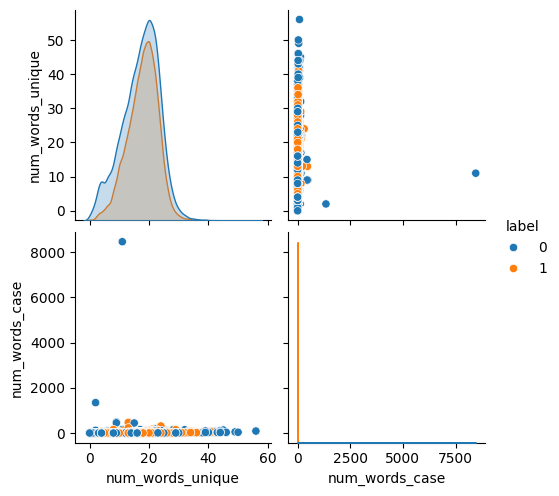

In [57]:
sns.pairplot(df[["num_words_unique","num_words_case", "label"]][:100000], hue = "label")

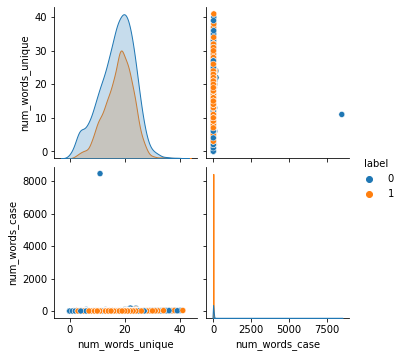

## MODELO


Build a Tf-Idf + logistic regression pipeline to predict sarcasm (`label`) based on the text of a comment on Reddit (`comment`)

In [58]:
tf_idf = TfidfVectorizer(ngram_range=(1,3), max_features=50000)

log_reg = LogisticRegression()

pipeline = Pipeline([("tf_idf", tf_idf),
                     ("log_reg", log_reg)])


In [59]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(max_features=50000, ngram_range=(1, 3))),
                ('log_reg', LogisticRegression())])

In [60]:
pred = pipeline.predict(X_test)

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [26]:

# pipeline = Pipeline([
#     ('vect', tf_idf),
#     ('cls', LogisticRegression())
# ])
# 
#  parameters = {
#      'vect__max_df': (0.5, 1 , 1.9),
#      'vect__min_df': (5, 10, 20,50),
#      'vect__max_features': (500, 1000),
#      "cls__penalty": ["l1","l2"], # Regularizaciones L1 y L2.
#      "cls__C": [0.1, 0.5, 1.0, 5.0] # Cuanta regularizacion queremos
#  
#  }
#  
#  grid_search = GridSearchCV(pipeline,
#                            parameters,
#                            cv = 5, #crossvalidation
#                            n_jobs = -1,
#                            scoring = 'accuracy')

In [62]:
# accuarcy

accuracy_score(y_test,pred)

0.722223046672108

In [36]:
# confusion matrix

<AxesSubplot:>

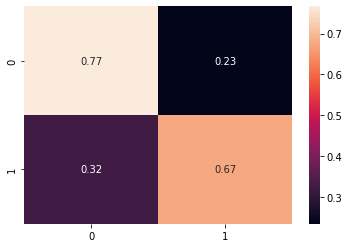

In [29]:
# pip install eli5

     ---------------------------------------- 0.0/216.2 kB ? eta -:--:--
     - -------------------------------------- 10.2/216.2 kB ? eta -:--:--
     ---------- -------------------------- 61.4/216.2 kB 544.7 kB/s eta 0:00:01
     ----------------------- ------------ 143.4/216.2 kB 950.9 kB/s eta 0:00:01
     -------------------------------------- 216.2/216.2 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)
Using cached jinja2-3.1.4-py3-none-any.whl (133 kB)
Using cached graphviz-0.20.3-py3-none-any.whl (47 kB)
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107762 sha256=be143bb8127c8265245748b5f78008920ee434bcef3524192349cd6a7fb86eda
  Stored in directory: c:\users\vipre\appdata\local\pip\cache\wheels\e0\e4\92\b2763717e9a525c427c049221a2fa8fa4d0ec6190bfc587

In [30]:
import eli5

ImportError: cannot import name 'if_delegate_has_method' from 'sklearn.utils.metaestimators' (c:\Users\vipre\anaconda3\envs\DL_ENV\Lib\site-packages\sklearn\utils\metaestimators.py)

In [46]:
eli5.show_weights(estimator=pipeline.named_steps['log_reg'],
                  vec=pipeline.named_steps['tf_idf'],
                  top = 50)

C:\Users\Miguel Angel\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



Weight?,Feature
+9.742,yes because
+7.732,clearly
+7.661,yeah because
+7.276,im sure
+7.239,obviously
+6.924,totally
+5.950,because
+5.777,right because
+5.739,dont you know
+5.711,how dare
